# Artist classification by painting

This project explores the merits of using machine learning in 
supplementing art experts’ efforts in identifying forgeries among disputed paintings. From the movement of brushstrokes to the use of light and dark, successful algorithms will likely incorporate many aspects of a painter's unique style. 

# Explanatory Data Analysis

### Download data

We will use the [Painter by Numbers](https://www.kaggle.com/competitions/painter-by-numbers/overview) from Kaggle. We will start by loading our data

In [ ]:
# Load the data
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && cp kaggle.json ~/.kaggle/ && echo 'Done'
! unzip all_data_info.csv.zip
! ls


kaggle.json
Done
Archive:  all_data_info.csv.zip
replace all_data_info.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: all_data_info.csv       
all_data_info.csv  all_data_info.csv.zip  kaggle.json  sample_data


Let's unzip the data

In [ ]:
import itertools
import zipfile
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import cv2
from PIL import Image
from skimage.feature import hog

from sklearn import preprocessing
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision import transforms, models



df = pd.read_csv('all_data_info.csv')

# (df['new_filename'] == 14955) if True
df=df.dropna()
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
7,Hiroshige,1838,bird-and-flower painting,6483.0,9276.0,12762418.0,wikiart,Ukiyo-e,Small Bird on a Branch of Kaidozakura,train_and_test,False,49823.jpg
8,Barnett Newman,1963.0,abstract,6049.0,8206.0,1135960.0,wikiart,Color Field Painting,Black Fire I,train_only,True,63861.jpg
10,Hiroshige,1844,bird-and-flower painting,5492.0,8283.0,10736273.0,wikiart,Ukiyo-e,Camellia and Bush Warbler,train_and_test,True,53180.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
103241,Tihamer Gyarmathy,1957.0,abstract,316.0,475.0,89274.0,wikiart,Abstract Art,Structures and Signs,train_and_test,True,36690.jpg
103242,Michelangelo,c.1509,nude painting (nu),314.0,478.0,32773.0,wikiart,High Renaissance,Ignudo,train_and_test,False,12758.jpg
103243,Andy Warhol,1954,animal painting,335.0,448.0,15709.0,wikiart,Pop Art,A Cat Named Sam,train_and_test,False,11921.jpg
103245,Jackson Pollock,1948.0,abstract,682.0,220.0,96405.0,wikiart,Action painting,Number 13A (Arabesque),train_and_test,True,25525.jpg


In [1]:
# ! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && cp kaggle.json ~/.kaggle/ && echo 'Done'
! unzip all_data_info.csv.zip
! ls        #load second zip and unzip

unzip:  cannot find or open all_data_info.csv.zip, all_data_info.csv.zip.zip or all_data_info.csv.zip.ZIP.
kaggle.json  sample_data


In [ ]:
import os
path = './image'
mode = 0o666
  
# flags
flags = os.O_RDWR | os.O_CREAT
  
  
# Open the specified file path
# using os.open() method
# and get the file descriptor for 
# opened file path
fd = os.open(path, flags, mode)

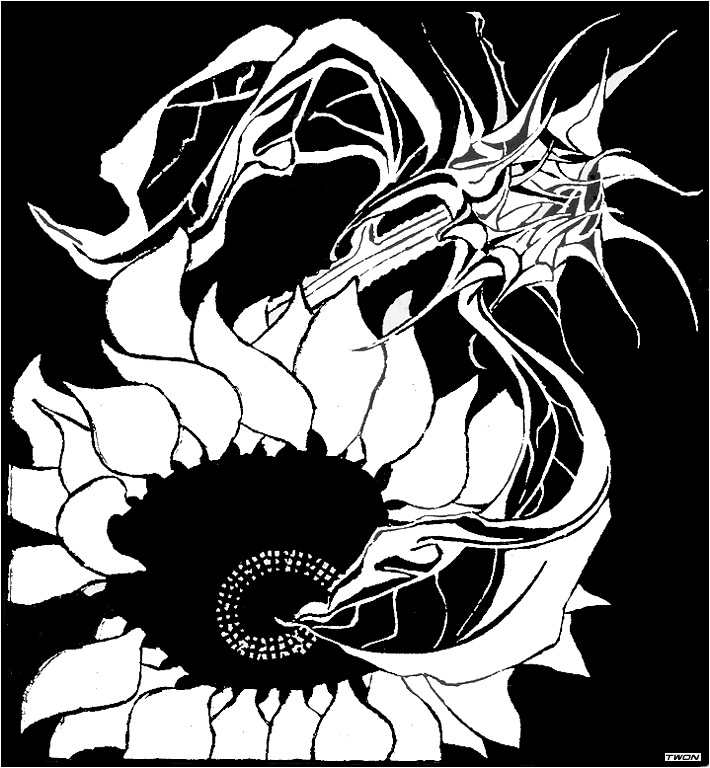

In [8]:
from PIL import Image
imP = Image.open('pictures/1.jpg')
imP

In [ ]:
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import preprocessing
from keras_preprocessing import image
# from keras_preprocessing.image import ImageDataGenerator
import pandas as pd
path = r"C:\Users\Rodrigo\PycharmProjects\capstone\train_1"
# path = r"C:\Users\Rodrigo\PycharmProjects\capstone\train_1\"

ending = '.jpg'
train_gen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range = 0.2)
# imP = Image.open(path + "\\1" + ending)
# C:\Users\Rodrigo\PycharmProjects\capstone\train_1\16.jpg
# imP.show()
df = pd.read_csv('all_data_info.csv')   # put names df into df
df = df.dropna() # drop any missing values
# df = df[["artist"],["date"],["genre"],["pixelsx"], ["pixelsy"],["style"],["new_file"]]
df = df.drop('size_bytes', axis=1)
df = df.drop('artist_group', axis=1)
df = df.drop('in_train', axis=1)
#EDA
print(df)
print(df["artist"].unique())        #unique names of artists
print(df.columns)
print(df["artist"].nunique())

count = df.groupby(['artist'])['artist'].count()
print(count.sort_values(ascending = False).head(10)) #10 most used authors

# for i in range(0 , df.shape[1]):
#     counts = df["artist"].value_counts()
#     gen = (f'{key} occurs {value} times' for key, value in counts.items())
#     print(*gen, sep=', ')
# for i in range(100):
#     imp = Image.open(path +"\\" + df["new_filename"][i])
#     imp.show()
# for i in range(100):
#     newDF = pd.DataFrame(path +"\\" + df["new_filename"][i]) == df["new_filename"]
# look at dataframe, search files to find name, if no match then drop
# for i in range(100):
#     try:
#         im[i] = Image.open(path + "\\" + df['new_filename'][i])
#         im[i].show()
#         break
#     except ValueError:
#         print("picture not found")